<a href="https://colab.research.google.com/github/JPD-Research/embeddings/blob/master/3-embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impact of Embeddings and Basic Inference work

Extension of core work [here](https://www.kaggle.com/code/redwankarimsony/nlp-101-understanding-word-embedding/notebook)

Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

Diagram of an embedding

![embedding image](https://github.com/JPD-Research/embeddings/blob/master/word_embeddings_colah.png?raw=1)

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

ToDo:
- Better understand how this changes with differences in training data
- extend for different corpus of text
- learn more about masking/padding

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [2]:
local_data_path_root = "."
local_data_path = local_data_path_root+ "/data"
local_vocab_path = local_data_path_root+ "/vocab/"
local_model_path = local_data_path_root+ "/models/"

# Directory where the checkpoints will be saved
checkpoint_dir = local_data_path_root + '/training_checkpoints'

In [3]:
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
logical_gpus = []
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

2.10.0
1 Physical GPUs, 1 Logical GPUs


The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer

In [4]:
embedding_layer = layers.Embedding(1000, 5)
# Here inside the Embedding(), the first number is the input_size and second one is the output_size

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [5]:
result = embedding_layer(tf.constant([1,2,3, 999]))
result.numpy()

array([[-0.03884544,  0.01931943, -0.03351586,  0.03340212,  0.02854147],
       [-0.04495316,  0.02606741,  0.02349416, -0.04589481,  0.0449588 ],
       [-0.00408622,  0.03470672,  0.04576988,  0.02244809,  0.02012898],
       [ 0.03613298,  0.03496009, -0.04010184,  0.0147672 , -0.00606412]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes  (32,10)
  (batch of 32 sequences of length 10) or  (64,15)
  (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a  (2,3)
  input batch and the output is  (2,3,N)

In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
print(result.shape)
print(result[0])
print(result[1])

(2, 3, 5)
tf.Tensor(
[[-0.02878994  0.04703298  0.02246911  0.03841518 -0.02851625]
 [-0.03884544  0.01931943 -0.03351586  0.03340212  0.02854147]
 [-0.04495316  0.02606741  0.02349416 -0.04589481  0.0449588 ]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[-0.00408622  0.03470672  0.04576988  0.02244809  0.02012898]
 [ 0.01857955 -0.00367036  0.02388165 -0.00272221  0.0465896 ]
 [-0.00067889  0.04677958  0.01161617  0.0164437  -0.00569593]], shape=(3, 5), dtype=float32)


Learning embeddings from scratch
Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. It contains a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional 50000 unlabeled data for use as well.

One of the common tricks is to use the total 100,000 samples to train a language model which essentially predicts the next word of a sequence given a series of words before that and later on using that model for classification. However, in this notebook, I am simply using them for demonstrating word embeddings. So, I will just work on a small subset of the whole dataset containing vocabulary size of 8,000 words. You are free to explore the other larger version of the dataset from the tensorflow dataframes on imdb reviews ready to use.

In [7]:
#(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k',
(train_data, test_data), info = tfds.load('imdb_reviews/subwords32k',
                                          split = (tfds.Split.TRAIN, tfds.Split.TEST),
                                          with_info=True,
                                          data_dir=local_data_path,
                                          as_supervised=True)

Get the encoder (tfds.features.text.SubwordTextEncoder), and have a quick look at the vocabulary. The "" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "") and partial words which it can use to build larger words:

In [8]:
encoder = info.features['text'].encoder
encoder.subwords[50:70]

['has_',
 'just_',
 'about_',
 'her_',
 ') ',
 'This_',
 'out_',
 'some_',
 'movie',
 'very_',
 'film',
 'more_',
 'It_',
 'would_',
 'what_',
 'when_',
 'which_',
 'good_',
 'if_',
 'up_']

Movie reviews can be different lengths. We will use the padded_batch method to standardize the lengths of the reviews.

In [9]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

As imported, the text of reviews is integer-encoded (each integer represents a specific word or word-part in the vocabulary). Note the trailing zeros, because the batch is padded to the longest example. Now lets have a look at the dataset summary.

In [10]:
train_batch, train_labels = next(iter(train_batches))
print('Training data info')
print('Train data shape: ', train_batch.shape)
print('Train_data: ', train_batch.numpy())


print('\n\nTrain label info')
print('Train label shape: ', train_labels.shape)
print('Train label: ', train_labels.numpy())

Training data info
Train data shape:  (10, 671)
Train_data:  [[   56    27    18 ...     0     0     0]
 [   12    76   180 ...     0     0     0]
 [   12    31    85 ...     0     0     0]
 ...
 [12188  7532  8679 ...     0     0     0]
 [  882   690     4 ...    12  1166 32440]
 [ 1936 29823     8 ...     0     0     0]]


Train label info
Train label shape:  (10,)
Train label:  [0 0 1 1 0 0 1 0 1 1]


Create a simple model
I will use the Keras Sequential API to define our model. In this case it is a "Continuous bag of words (CBOW)" style model. In the CBOW model, the distributed representations of context (or surrounding words) are combined to predict the word in the middle. The exact opposite model is the Skip-Gram model, that is based on a single target word, the sorrounding words (contexts) are predicted The following figure will clarify them for sure.

Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output. To fix this, see the masking and padding guide.

In [11]:
embedding_dim = 300

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
#  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         9795000   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 9,795,301
Trainable params: 9,795,301
Non-trainable params: 0
_________________________________________________________________


Compile and train the model

Note that this took approximately twice as long running on basic CPU than running on GPU.
for embedding_dim = 16, it was about 1:20 on GPU and 3:00 on CPU
Surprisingly, the training time did not significantly increase for embedding_dim = 300

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
history = model.fit(train_batches,
                    epochs=5,
                    validation_data=test_batches,
                    validation_steps=250)

Epoch 1/5
2500/2500 [==============================] - 21s 7ms/step - loss: 0.4806 - accuracy: 0.7252 - val_loss: 0.3596 - val_accuracy: 0.8688
Epoch 2/5
2500/2500 [==============================] - 17s 7ms/step - loss: 0.2503 - accuracy: 0.9001 - val_loss: 0.3133 - val_accuracy: 0.8892
Epoch 3/5
2500/2500 [==============================] - 17s 7ms/step - loss: 0.1699 - accuracy: 0.9384 - val_loss: 0.3439 - val_accuracy: 0.8696
Epoch 4/5
2500/2500 [==============================] - 17s 7ms/step - loss: 0.1158 - accuracy: 0.9606 - val_loss: 0.3339 - val_accuracy: 0.8840
Epoch 5/5
2500/2500 [==============================] - 17s 7ms/step - loss: 0.0809 - accuracy: 0.9752 - val_loss: 0.4013 - val_accuracy: 0.8760


In [14]:
def visualize_training(history, lw = 3):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')


    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()

#    plt.figure(figsize=(10,5))
#    plt.plot(history.history['lr'], label = 'lr', marker = '*',linewidth = lw)
#    plt.title('Learning Rate')
#    plt.xlabel('Epochs')
#    plt.ylabel('Learning Rate')
#    plt.grid(True)
#    plt.show()

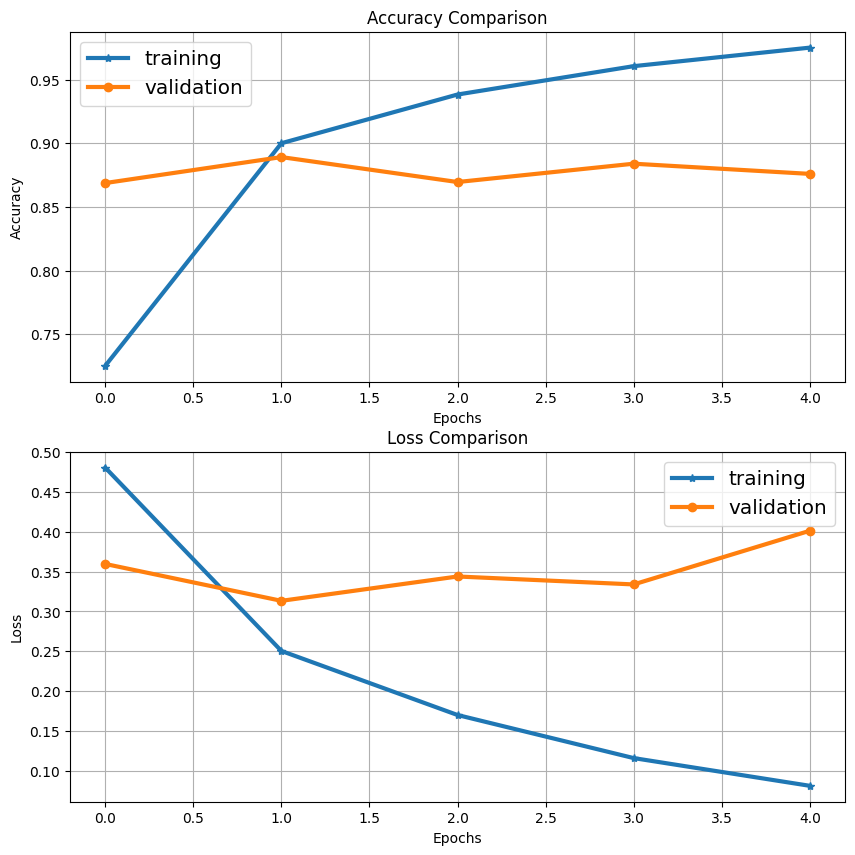

In [15]:
visualize_training(history)

Retrieve the learned embeddings
Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape (vocab_size, embedding-dimension). Here observe some things carefully.

We are selecting only the first layer of the model because it is the embedding layer in our model descriptor. If you carefully look at the model description, you can get an idea of what I am talking about.

When we run the summary() command for the model, we saw that Embedding() layer had 1044800 parameters. Which is exactly equal to 32,650x32 = 1044800. Therefore it was basically telling the size of the embedding matrix that it was going to learn. However for the quick testing purpose, I would set embedding_dim = 32 or 16.

In the summary of the model, we observe that global_average_pooling1d layer which is GlobalAveragePooling1D() has 0 parameters to learn because it was simply finding out the running average of the previous layers output.

Similarly it is possible to explore the learned parameters of the last two layers. Feel free to explore them for better understanding.

In [16]:
# Retrieving the layer
e = model.layers[0]
#Retrieving the weights learned in that layer.
weights = e.get_weights()[0]
# The weight matrix is basically a list type matrix. Let's convert them into a numpy array for easier visualization.
print(weights.shape)

(32650, 300)


We will now write the weights to disk. To use the Embedding Projector, we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [17]:
import io

encoder = info.features['text'].encoder

out_v = io.open(local_model_path+'vecs.tsv', 'w', encoding='utf-8')
out_m = io.open(local_model_path+'meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

After you have run the previous segment of code, your output folder should have two files named

vecs.tsv
meta.tsv
To visualize our embeddings we will upload them to the embedding projector.

Open the Embedding Projector (this can also run in a local TensorBoard instance).
https://projector.tensorflow.org/

Click on "Load data".

Upload the two files we created above: vecs.tsv and meta.tsv.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".

Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.

Note: experimentally, you may be able to produce more interpretable embeddings by using a simpler model. Try deleting the Dense(16) layer, retraining the model, and visualizing the embeddings again.

Now in order to find or have a look at any words in the embedding, we just have to find the location of that word in the vocabulary and select that row from the embedding matrix. This mechanism is very well explained in the tutorial of Andrew Ng

Let's find the location of the words man, woman, king, queen from the vocabulary and then retrieve their word embedding.

In [18]:
def get_location(word, vocab):
    location = None
    for index, s in enumerate(vocab):
        if(s == word):
            print('Found ', s)
            location = index
            break
    return location
vocab = encoder.subwords

man = weights[get_location("man", vocab)]
woman = weights[get_location("woman", vocab)]
boy = weights[get_location("boy", vocab)]
girl = weights[get_location("girl", vocab)]

king = weights[get_location("king", vocab)]
queen = weights[get_location("queen", vocab)]

dog = weights[get_location("dog", vocab)]
cat = weights[get_location("cat", vocab)]
pet = weights[get_location("pet", vocab)]

prince = weights[get_location("prince", vocab)]
princess = weights[get_location("princess", vocab)]
young = weights[get_location("young", vocab)]
old = weights[get_location("old", vocab)]

weights.size
king.size

Found  man
Found  woman
Found  boy
Found  girl
Found  king
Found  queen
Found  dog
Found  cat
Found  pet
Found  prince
Found  princess
Found  young
Found  old


300

In [19]:
# a:b = c:d, (b-a) = (d-c), d = c + (b - a), or c = d - (b-a)
what = boy + (woman - man)      # man:woman = boy: ?
what1a = woman + (boy - man)  # man:boy = woman: ?
what2 = man + (queen - king)      # king:queen = man: ?
what3 = queen + prince - king   # king:prince = queen : ?


v1 = woman - man
v2 = girl - boy

Now for comparative analysis, lets calculate the similarity of what with each of them

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

print('Similarity between   man & what  : ', np.squeeze(cosine_similarity([what], [man])))
print('Similarity between   woman & what: ', np.squeeze(cosine_similarity([what], [woman])))
print('Similarity between   boy & what  : ', np.squeeze(cosine_similarity([what], [boy])))
print('Similarity between   girl & what : ', np.squeeze(cosine_similarity([what], [girl])))
print()
print('Similarity between   man & what1a  : ', np.squeeze(cosine_similarity([what1a], [man])))
print('Similarity between   woman & what1a: ', np.squeeze(cosine_similarity([what1a], [woman])))
print('Similarity between   boy & what1a  : ', np.squeeze(cosine_similarity([what1a], [boy])))
print('Similarity between   girl & what1a : ', np.squeeze(cosine_similarity([what1a], [girl])))
print()
print('Similarity between   man & what2  : ', np.squeeze(cosine_similarity([what2], [man])))
print('Similarity between   woman & what2: ', np.squeeze(cosine_similarity([what2], [woman])))
print('Similarity between   king & what2  : ', np.squeeze(cosine_similarity([what2], [king])))
print('Similarity between   queen & what2 : ', np.squeeze(cosine_similarity([what2], [queen])))
print()
print('Similarity between   man & what3  : ', np.squeeze(cosine_similarity([what3], [man])))
print('Similarity between   woman & what3: ', np.squeeze(cosine_similarity([what3], [woman])))
print('Similarity between   king & what3  : ', np.squeeze(cosine_similarity([what3], [king])))
print('Similarity between   queen & what3 : ', np.squeeze(cosine_similarity([what3], [queen])))
print('Similarity between   princess & what3 : ', np.squeeze(cosine_similarity([what3], [princess])))
print()
print('Similarity between   v1 & v2  : ', np.squeeze(cosine_similarity([v1], [v2])))
print()
print('Similarity between   dog & cat  : ', np.squeeze(cosine_similarity([dog], [cat])))
print()
print('Similarity between   dog & cat as pets  : ', np.squeeze(cosine_similarity([dog-pet], [cat-pet])))
print()
print('Similarity between   man & man  : ', np.squeeze(cosine_similarity([man], [man])))


Similarity between   man & what  :  -0.958369
Similarity between   woman & what:  -0.7082801
Similarity between   boy & what  :  -0.20145985
Similarity between   girl & what :  0.9390875

Similarity between   man & what1a  :  -0.9583691
Similarity between   woman & what1a:  -0.70828015
Similarity between   boy & what1a  :  -0.20145988
Similarity between   girl & what1a :  0.9390876

Similarity between   man & what2  :  0.99461746
Similarity between   woman & what2:  0.85480314
Similarity between   king & what2  :  -0.8608711
Similarity between   queen & what2 :  0.99171865

Similarity between   man & what3  :  0.9084393
Similarity between   woman & what3:  0.7851814
Similarity between   king & what3  :  -0.89686835
Similarity between   queen & what3 :  0.94257855
Similarity between   princess & what3 :  0.88086903

Similarity between   v1 & v2  :  0.9621216

Similarity between   dog & cat  :  0.9062699

Similarity between   dog & cat as pets  :  -0.2776531

Similarity between   man & m

Inference / similarity for cases with embedded_dim = 16


| case | man | woman | boy | girl |
|------|------|------|------|-----|
| 1 (girl - gender) |-0.9724242|-0.6498057|0.9286064|0.9648668|
| 1a (girl - gender/child) |-0.9724242|-0.6498058|0.9286064|0.9648668|


| case | man | woman | king | queen |
|------|------|------|------|-----|
| 2 (woman - role) |0.99398476|0.7802019|-0.9537238|0.9904202|

| case | man | woman | king | queen | princess |
|------|------|------|------|-----|-----|
| 3 (princess - gender/role) |0.96157044|0.7590729|-0.95998454|0.9786165|0.9300556|

| case | woman:man |
|------|------|
| girl:boy |0.9576211|

| case | cat |
|------|------|
| dog |0.77308697|

| case | dog:pet |
|------|------|
| cat:pet |-0.1196607|

.9999998
Selection deleted


Inference / similarity for cases with embedded_dim = 16


| case | man | woman | boy | girl |
|------|------|------|------|-----|
| 1 (girl - gender) |-0.9797869|-0.8006046|0.9028366|0.96941024|
| 1a (girl - gender/child) |-0.9797869|-0.8006046|0.9028366|0.96941024|


| case | man | woman | king | queen |
|------|------|------|------|-----|
| 2 (woman - role) |0.99546474|0.8843986|-0.8285873|0.985227|

| case | man | woman | king | queen | princess |
|------|------|------|------|-----|-----|
| 3 (princess - gender/role) |0.91367143|0.81733966|-0.86102426|0.94154096|0.8833039|

| case | woman:man |
|------|------|
| girl:boy |0.9634705|

| case | cat |
|------|------|
| dog |0.8988646|

| case | dog:pet |
|------|------|
| cat:pet |-0.5276349|
pets  :  -0.5276349



at embeddings_dim = 16, most expected relationships are clear, althought there are several spurious with high ranking results as well.
at embeddings_dim = 300, most expected relationships, althought there are several spurious with high ranking results as well.

These inferences show a high degree of simiarity between roles that have overlapping common contextual usage, such as cat/dog or the usage of girl or boy in relation to woman or man.  The more role or context based inferences show cases where poor inferences such as case 2: king:queen = man:man being preferred at the higher dimensionality over the expected king:queen = man:woman, which is likely a case of overfitting.
